<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled293.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

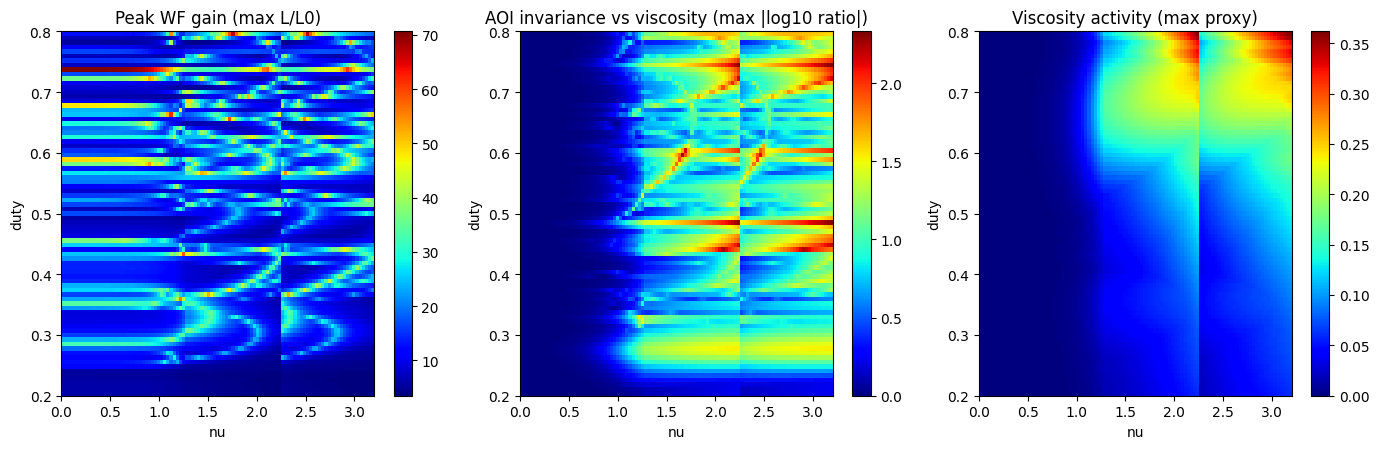

Saved: FFSfig3.png
Saved: FFSfig3.npz
Shapes: PK (81, 101) D (81, 101) VP (81, 101)


In [ ]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# =========================
# FIG3 (RECOMPUTE): 3-panel sweep in JET
# Saves: FFSfig3.png  and  FFSfig3.npz
# =========================

# ---------------------------
# Affine dynamics
# ---------------------------
def affine_segment(A, S, dt):
    E = expm(-A * dt)
    x_ss = np.linalg.solve(A, S)
    g = (np.eye(A.shape[0]) - E) @ x_ss
    return E, g

def affine_one_period(A1, A2, S, P, duty):
    t1 = duty * P
    t2 = (1.0 - duty) * P
    E1, g1 = affine_segment(A1, S, t1)
    E2, g2 = affine_segment(A2, S, t2)
    M = E2 @ E1
    b = E2 @ g1 + g2
    return M, b

def steady_state_direct(A1, A2, S, P, duty):
    M, b = affine_one_period(A1, A2, S, P, duty)
    return np.linalg.solve(np.eye(M.shape[0]) - M, b)

def averaged_steady(Aavg, S):
    return np.linalg.solve(Aavg, S)

# ---------------------------
# Baseline parameters
# ---------------------------
Gamma_c = 2.0
Gamma_s = 0.8
Gamma_p = 0.05
Gamma_I = 0.25

g_sp = 18.0
g_sI = 3.0

g_cp_on  = 16.0
g_cp_off = 0.3
g_cI_on  = 10.0
g_cI_off = 0.3

omega = 4.0
eps_dephase = 0.005

sigma_bg = 0.005
kappa_bg = 0.001

S_E = np.array([1.0, 0.0, 0.0, 0.6])
S_T = np.array([0.0, 1.0, 0.8, 0.0])

# Period grid used inside each sweep evaluation
periods = np.logspace(-4, 1.5, 90)

# Viscosity proxy bilinear form
V = np.diag([0.0, 0.0, 1.0, 1.0])

def make_A(g_cp, g_cI, twist_sign, nu, omega_local):
    Gamma_p_eff = Gamma_p + nu
    A = np.array([
        [Gamma_c, 0.0,          -g_cp,        -g_cI],
        [0.0,     Gamma_s,      -g_sp,        -g_sI],
        [g_cp,    g_sp,     Gamma_p_eff,       0.0],
        [g_cI,    g_sI,          0.0,      Gamma_I],
    ], dtype=float)

    if omega_local != 0.0:
        A += twist_sign * np.array([
            [0.0, -omega_local, 0.0, 0.0],
            [omega_local, 0.0,  0.0, 0.0],
            [0.0, 0.0,          0.0, -omega_local],
            [0.0, 0.0,     omega_local, 0.0],
        ], dtype=float)

    A += eps_dephase * np.eye(4)
    return A

def run_case(nu, duty_local, omega_local):
    A_E = make_A(g_cp_off, g_cI_off, +1.0, nu, omega_local)
    A_Q = make_A(g_cp_on,  g_cI_on,  -1.0, nu, omega_local)
    A_avg = 0.5 * (A_E + A_Q)

    sig_q = np.zeros_like(periods, dtype=float)
    kap_q = np.zeros_like(periods, dtype=float)
    sig_a = np.zeros_like(periods, dtype=float)
    kap_a = np.zeros_like(periods, dtype=float)
    visc  = np.zeros_like(periods, dtype=float)

    for iP, P in enumerate(periods):
        # averaged (QGE-only)
        xE_q = averaged_steady(A_avg, S_E)
        xT_q = averaged_steady(A_avg, S_T)

        # ordered (direct fixed point / AOI)
        xE_a = steady_state_direct(A_E, A_Q, S_E, P, duty_local)
        xT_a = steady_state_direct(A_E, A_Q, S_T, P, duty_local)

        sig_q[iP] = abs(xE_q[0]) + sigma_bg
        kap_q[iP] = abs(xT_q[1]) + kappa_bg
        sig_a[iP] = abs(xE_a[0]) + sigma_bg
        kap_a[iP] = abs(xT_a[1]) + kappa_bg

        visc[iP]  = nu * float(xE_a.T @ V @ xE_a)

    L_q = kap_q / np.maximum(sig_q, 1e-15)
    L_a = kap_a / np.maximum(sig_a, 1e-15)
    L0  = float(np.median(L_q))

    return (L_a / max(L0, 1e-12)), visc

def diff_metric(La_nu, La0):
    eps = 1e-12
    return float(np.max(np.abs(np.log10((La_nu + eps) / (La0 + eps)))))

# ---------------------------
# SWEEP GRIDS (tune these)
# ---------------------------
# ν sweep spans orders of magnitude (so reviewers can't say "ν is tiny")
nu_vals = np.concatenate((
    [0.0],
    np.logspace(-4, -0.1, 20),
    np.logspace(-0.1, 0.5, 12),
    np.linspace(0.9, 3.16227766, 12)  # extend to ~3.16 smoothly
))
# duty sweep
duty_vals = np.linspace(0.2, 0.8, 31)

omega_fixed = omega

# ---------------------------
# COMPUTE HEATMAPS
# ---------------------------
D  = np.zeros((len(duty_vals), len(nu_vals)), dtype=float)  # AOI invariance metric
PK = np.zeros((len(duty_vals), len(nu_vals)), dtype=float)  # peak WF gain (max L/L0)
VP = np.zeros((len(duty_vals), len(nu_vals)), dtype=float)  # viscosity activity (max proxy)

for i, duty_local in enumerate(duty_vals):
    La0, visc0 = run_case(0.0, duty_local, omega_fixed)
    for j, nu in enumerate(nu_vals):
        La, visc = run_case(float(nu), duty_local, omega_fixed)
        D[i, j]  = diff_metric(La, La0)
        PK[i, j] = float(np.max(La))
        VP[i, j] = float(np.max(np.abs(visc)))

# ---------------------------
# PLOT (JET) — barcode-preserving
# ---------------------------
fig = plt.figure(figsize=(14, 4.6))

# x-axis: use real ν values (not index) so it's honest + readable
extent = [nu_vals.min(), nu_vals.max(), duty_vals.min(), duty_vals.max()]

ax1 = fig.add_subplot(1, 3, 1)
im1 = ax1.imshow(
    PK, origin="lower", aspect="auto", extent=extent,
    cmap="jet", interpolation="nearest"
)
ax1.set_title("Peak WF gain (max L/L0)")
ax1.set_xlabel("nu")
ax1.set_ylabel("duty")
fig.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 3, 2)
im2 = ax2.imshow(
    D, origin="lower", aspect="auto", extent=extent,
    cmap="jet", interpolation="nearest"
)
ax2.set_title("AOI invariance vs viscosity (max |log10 ratio|)")
ax2.set_xlabel("nu")
ax2.set_ylabel("duty")
fig.colorbar(im2, ax=ax2)

ax3 = fig.add_subplot(1, 3, 3)
im3 = ax3.imshow(
    VP, origin="lower", aspect="auto", extent=extent,
    cmap="jet", interpolation="nearest"
)
ax3.set_title("Viscosity activity (max proxy)")
ax3.set_xlabel("nu")
ax3.set_ylabel("duty")
fig.colorbar(im3, ax=ax3)

plt.tight_layout()

# ---------------------------
# SAVE PNG + NPZ (codename)
# ---------------------------
png_name = "FFSfig3.png"
npz_name = "FFSfig3.npz"

plt.savefig(png_name, dpi=350, bbox_inches="tight")
plt.show()

np.savez(
    npz_name,
    nu_vals=nu_vals,
    duty_vals=duty_vals,
    periods=periods,
    D=D,
    PK=PK,
    VP=VP,
    params_json=json.dumps(
        dict(
            Gamma_c=Gamma_c, Gamma_s=Gamma_s, Gamma_p=Gamma_p, Gamma_I=Gamma_I,
            g_sp=g_sp, g_sI=g_sI,
            g_cp_on=g_cp_on, g_cp_off=g_cp_off,
            g_cI_on=g_cI_on, g_cI_off=g_cI_off,
            omega=omega_fixed,
            eps_dephase=eps_dephase,
            sigma_bg=sigma_bg, kappa_bg=kappa_bg
        ),
        sort_keys=True
    )
)

print("Saved:", png_name)
print("Saved:", npz_name)
print("Shapes: PK", PK.shape, "D", D.shape, "VP", VP.shape)